N: 1210271 M: 249274
N // batch_size: 18910
mu: 4.149055643156193


2021-10-24 14:57:56.863463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 14:57:56.981048: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 14:57:56.982020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-24 14:57:56.983622: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/5
18911/18911 [==============================] - 13078s 691ms/step - loss: 1.6947 - custom_loss: 1.5884 - val_loss: 1.7053 - val_custom_loss: 1.6257
Epoch 2/5
18911/18911 [==============================] - 13063s 691ms/step - loss: 1.5823 - custom_loss: 1.4995 - val_loss: 1.6855 - val_custom_loss: 1.6116
Epoch 3/5
18911/18911 [==============================] - 13125s 694ms/step - loss: 1.5398 - custom_loss: 1.4658 - val_loss: 1.6755 - val_custom_loss: 1.6069
Epoch 4/5
18911/18911 [==============================] - 13082s 692ms/step - loss: 1.5099 - custom_loss: 1.4399 - val_loss: 1.6701 - val_custom_loss: 1.6037
Epoch 5/5
18911/18911 [==============================] - 13035s 689ms/step - loss: 1.4884 - custom_loss: 1.4193 - val_loss: 1.6701 - val_custom_loss: 1.6016
dict_keys(['loss', 'custom_loss', 'val_loss', 'val_custom_loss'])


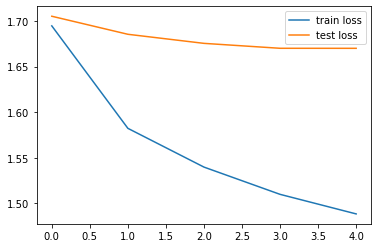

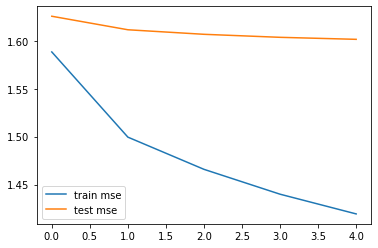

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from scipy.sparse import save_npz, load_npz

import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Dense
from keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

# config
batch_size = 64
epochs = 5
reg = 0.0001
# reg = 0

A = load_npz("Atrain_beauty.npz")
A_test = load_npz("Atest_beauty.npz")
mask = (A > 0) * 1.0
mask_test = (A_test > 0) * 1.0

# make copies since we will shuffle
A_copy = A.copy()
mask_copy = mask.copy()
A_test_copy = A_test.copy()
mask_test_copy = mask_test.copy()

N, M = A.shape
print("N:", N, "M:", M)
print("N // batch_size:", N // batch_size)

# center the data
mu = A.sum() / mask.sum()
print("mu:", mu)



# build the model - just a 1 hidden layer autoencoder
i = Input(shape=(M,))
# bigger hidden layer size seems to help!
x = Dropout(0.7)(i)
x = Dense(700, activation='tanh', kernel_regularizer=l2(reg))(x)
# x = Dropout(0.5)(x)
x = Dense(M, kernel_regularizer=l2(reg))(x)



def custom_loss(y_true, y_pred):
  mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
  diff = y_pred - y_true
  sqdiff = diff * diff * mask
  sse = K.sum(K.sum(sqdiff))
  n = K.sum(K.sum(mask))
  return sse / n


def generator(A, M):
  while True:
    A, M = shuffle(A, M)
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
      a = a - mu * m # must keep zeros at zero!
      # m2 = (np.random.random(a.shape) > 0.5)
      # noisy = a * m2
      noisy = a # no noise
      yield noisy, a


def test_generator(A, M, A_test, M_test):
  # assumes A and A_test are in corresponding order
  # both of size N x M
  while True:
    for i in range(A.shape[0] // batch_size + 1):
      upper = min((i+1)*batch_size, A.shape[0])
      a = A[i*batch_size:upper].toarray()
      m = M[i*batch_size:upper].toarray()
      at = A_test[i*batch_size:upper].toarray()
      mt = M_test[i*batch_size:upper].toarray()
      a = a - mu * m
      at = at - mu * mt
      yield a, at



model = Model(i, x)
model.compile(
  loss=custom_loss,
  optimizer=SGD(learning_rate=0.08, momentum=0.9),
  # optimizer='adam',
  metrics=[custom_loss],
)


r = model.fit_generator(
  generator(A, mask),
  validation_data=test_generator(A_copy, mask_copy, A_test_copy, mask_test_copy),
  epochs=epochs,
  steps_per_epoch=A.shape[0] // batch_size + 1,
  validation_steps=A_test.shape[0] // batch_size + 1,
)
print(r.history.keys())



# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

# plot mse
plt.plot(r.history['custom_loss'], label="train mse")
plt.plot(r.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()

In [4]:
model.save('autorec.h5')